# Analyse de la popularité des recettes

In [ ]:
from pathlib import Path
import importlib.util

import ipynbname # permet de trouver le chemin du notebook en cours
REPO_ROOT = ipynbname.path().parents[2]  # dataset_analysis/popularity -> dataset_analysis -> racine
print("Racine détectée:", REPO_ROOT)

script_path = REPO_ROOT / "scripts" / "download_data.py"
spec = importlib.util.spec_from_file_location("download_data", script_path)
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

mod.download_and_extract()  # télécharge dans <repo>/data/


Racine détectée: /Users/gregoirepetit/mangetamain
Racine projet : /Users/gregoirepetit/mangetamain
Téléchargement vers : /Users/gregoirepetit/mangetamain/data
Dataset URL: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
✅ Téléchargement terminé.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import des datasets
data_path = REPO_ROOT / "data"
recipes = pd.read_csv(data_path / "RAW_recipes.csv")
interactions = pd.read_csv(data_path / "RAW_interactions.csv")

## Exploration initiale des données

Commençons par comprendre la structure des données et identifier les métriques de popularité disponibles.

In [6]:
recipes.head() # Afficher les premières lignes du DataFrame des recettes

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [7]:
interactions.head() # Afficher les premières lignes du DataFrame des interactions

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


- On peut repérer quelques colonnes intéressantes dans les datasets :
  - Dans `RAW_recipes.csv` : `id`, `minutes`, `submitted`, `n_steps`, `n_ingredients`, `contributor_id`
  - Dans `RAW_interactions.csv` : `user_id`, `recipe_id`, `rating`, `date`, `review`.

In [8]:
# On contrôle les valeurs manquantes
print("Valeurs manquantes dans les recettes par variable: \n", recipes.isna().sum(), "\n")
print("Valeurs manquantes dans les interactions par variable: \n", interactions.isna().sum())

Valeurs manquantes dans les recettes par variable: 
 name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64 

Valeurs manquantes dans les interactions par variable: 
 user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64


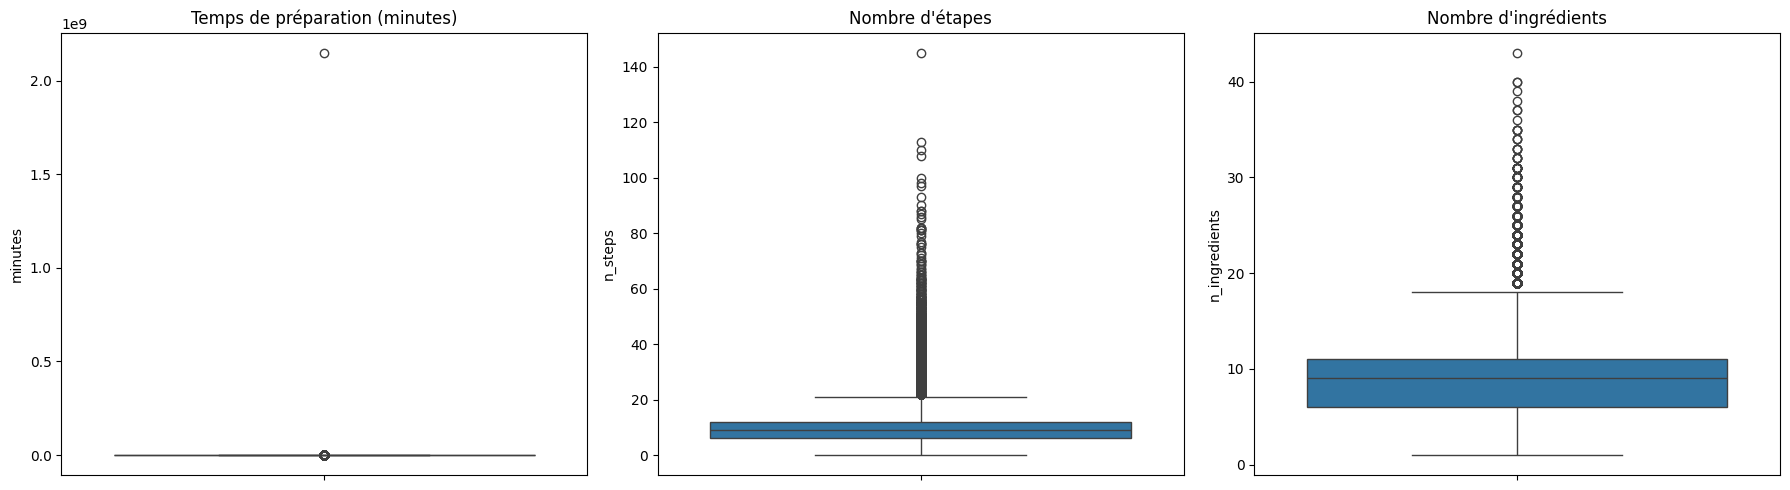

In [9]:
# On trace des boxplots pour visualiser la distribution de certaines variables numériques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=recipes['minutes'], ax=axes[0])
axes[0].set_title('Temps de préparation (minutes)')
axes[0].set_ylabel('minutes')

sns.boxplot(y=recipes['n_steps'], ax=axes[1])
axes[1].set_title("Nombre d'étapes")
axes[1].set_ylabel('n_steps')

sns.boxplot(y=recipes['n_ingredients'], ax=axes[2])
axes[2].set_title("Nombre d'ingrédients")
axes[2].set_ylabel('n_ingredients')

plt.tight_layout()
plt.show()

- Les distributions du temps de préparation (`minutes`), du nombre d'étapes (`n_steps`) et du nombre d'ingrédients (`n_ingredients`) sont toutes très asymétriques, avec une majorité de recettes ayant des valeurs faibles et quelques recettes extrêmes tirant les distributions vers le haut.
- On observe la présence de nombreux outliers, en particulier pour le temps de préparation, ce qui indique que certaines recettes demandent beaucoup plus de temps que la moyenne.
- La plupart des recettes nécessitent un nombre modéré d'étapes et d'ingrédients, mais il existe des recettes très complexes avec de nombreux ingrédients ou étapes.
- Ces variables présentent donc une forte hétérogénéité, ce qui devra être pris en compte dans l’analyse de la popularité des recettes.

### Traitement : 'minutes'

In [10]:
# Afficher la recette avec le temps de préparation minimum
print("Recette avec le temps de préparation minimum :")
recipes.loc[[recipes['minutes'].idxmin()]]

Recette avec le temps de préparation minimum :


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
5,apple a day milk shake,5289,0,1533,1999-12-06,"['15-minutes-or-less', 'time-to-make', 'course...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4


In [11]:
# Afficher la recette avec le temps de préparation maximum
print("Recette avec le temps de préparation maximum :")
recipes.loc[[recipes['minutes'].idxmax()]]  # Double brackets = DataFrame

Recette avec le temps de préparation maximum :


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
144074,no bake granola balls,261647,2147483647,464080,2007-10-26,"['60-minutes-or-less', 'time-to-make', 'course...","[330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]",9,"['preheat the oven to 350 degrees', 'spread oa...",healthy snacks that kids (and grown ups) will ...,"['rolled oats', 'unsweetened dried shredded co...",8


- On constate un temps anormalement grand pour le temps de préparation maximum&nbsp;:
  
  > 2&nbsp;147&nbsp;483&nbsp;647 minutes  
  > soit environ `4085.8 ans` (`2147483647 / (60 × 24 × 365)`), ce qui est clairement une erreur ou une valeur aberrante.

- Nous faisons le choix de retirer cette valeur extrême de notre analyse pour éviter qu'elle n'influence les résultats.
- On remarque également que certaines recettes ont un temps de préparation de 0 minutes, ce qui est probablement une erreur ou une valeur manquante mal codée. Nous allons les traiter en les remplaçant par des valeurs NA.

In [12]:
# Retirer la recette avec le temps de préparation maximum (valeur aberrante)
recipes = recipes[recipes['minutes'] != recipes['minutes'].max()]

# Indiquer NA pour celles qui ont 0 minutes
recipes.loc[recipes['minutes'] == 0, 'minutes'] = pd.NA

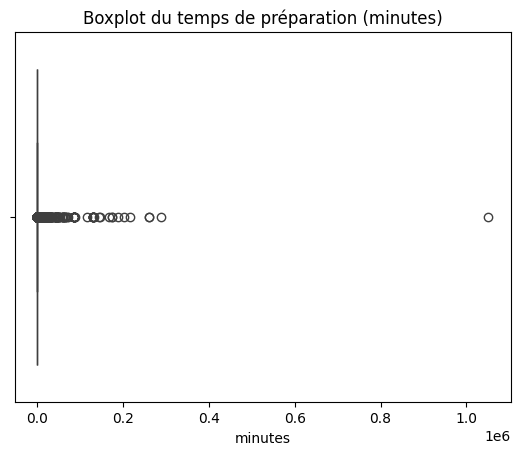

In [13]:
# Nouveau boxplot pour constater la distribution après le traitement
sns.boxplot(x = 'minutes', data = recipes)
plt.title("Boxplot du temps de préparation (minutes)")
plt.xlabel("minutes")
plt.show()

In [14]:
# On affiche les 5 recettes avec le plus grand temps de préparation (minutes)
recipes.sort_values('minutes', ascending=False).head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
109624,how to preserve a husband,447963,1051200.0,576273,2011-02-01,"['time-to-make', 'course', 'preparation', 'for...","[407.4, 57.0, 50.0, 1.0, 7.0, 115.0, 5.0]",9,"['be careful in your selection', ""don't choose...","found this in a local wyoming cookbook ""a coll...","['cream', 'peach']",2
106563,homemade fruit liquers,291571,288000.0,553251,2008-03-12,"['time-to-make', 'course', 'main-ingredient', ...","[836.2, 0.0, 333.0, 0.0, 0.0, 0.0, 27.0]",12,"['rinse the fruit or berries , fruit must be c...",this should be a nice easy project for those w...,"['berries', 'vodka', 'granulated sugar']",3
38116,celtic druid s honey mead meade metheglin,216215,259260.0,242729,2007-03-11,"['time-to-make', 'course', 'main-ingredient', ...","[531.0, 0.0, 561.0, 1.0, 1.0, 0.0, 47.0]",18,"['equipement:', 'very large pan - to hold 12 p...","mead, made from fermented honey, was the earli...","['gingerroot', 'lemons, juice and rind of', 'w...",7
106963,homemade vanilla,425681,259205.0,28177,2010-05-16,"['time-to-make', 'preparation', '5-ingredients...","[69.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9,['slice the vanilla beans length-wise and scra...,found this recipe on tammy's blog (http://www....,"['vanilla beans', 'vodka']",2
155044,peach brandy,98912,216015.0,34146,2004-09-01,"['time-to-make', 'course', 'main-ingredient', ...","[3645.3, 3.0, 2040.0, 0.0, 16.0, 0.0, 173.0]",9,"['use only fully ripened , unblemished fruit',...",posted in reply to a message board request for,"['fresh peaches', 'granulated sugar', 'honey',...",4


- La recette "how to preserve a husband" semble être une plaisanterie ou une erreur de saisie plutôt qu'une vraie recette, son temps de préparation étant aussi significativement au-dessus des autres sans élément concret pour le justifier. 
  - Nous ferons le choix de la retirer pour la suite de l'analyse.
- Il semblerait que que le reste des recettes correspondent à des fermentations, d'où leur durée très grande.


In [15]:
# On retire la recette "how to preserve a husband"
recipes = recipes[recipes['minutes'] != recipes['minutes'].max()]

In [16]:
# Calculs des statistiques descriptives de la colonne 'minutes'
stats_minutes = recipes['minutes'].describe()
stats_minutes['variance'] = recipes['minutes'].var()
stats_minutes['skewness'] = recipes['minutes'].skew()
stats_minutes['kurtosis'] = recipes['minutes'].kurtosis()
stats_minutes

count       2.305410e+05
mean        1.236923e+02
std         1.982437e+03
min         1.000000e+00
25%         2.000000e+01
50%         4.000000e+01
75%         6.500000e+01
max         2.880000e+05
variance    3.930055e+06
skewness    7.784528e+01
kurtosis    7.848984e+03
Name: minutes, dtype: float64

- Les statistiques descriptives de la colonne `minutes` montrent une forte asymétrie :
    - La médiane (50%) est de 40 minutes, alors que la moyenne est beaucoup plus élevée (~123,7 minutes), ce qui indique la présence de valeurs extrêmes tirant la moyenne vers le haut.
    - L'écart-type est très grand (1982 minutes), bien supérieur à la médiane, ce qui confirme la dispersion importante des temps de préparation.
    - Le minimum est de 1 minute, le maximum de 288 000 minutes (soit 200 jours), ce qui révèle des valeurs aberrantes ou des recettes très particulières (fermentations, erreurs de saisie).
    - Le skewness (asymétrie) et la kurtosis (aplatissement) sont extrêmement élevés, ce qui traduit une distribution très éloignée de la normale, avec de nombreux outliers.

- Passer en échelle logarithmique permet de mieux visualiser la distribution des temps de préparation :
    - L'échelle linéaire "écrase" la majorité des recettes (à faible durée) à cause de quelques valeurs extrêmes.
    - L'échelle logarithmique "compresse" les grandes valeurs et "étale" les petites, rendant la distribution plus lisible et permettant d'observer les tendances pour la majorité des recettes, tout en conservant l'information sur les valeurs élevées.

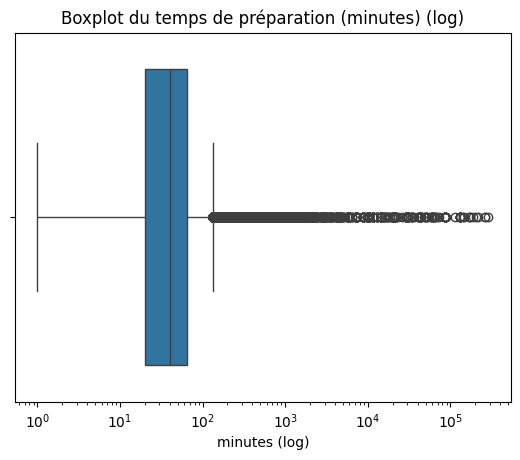

In [17]:
ax = sns.boxplot(x='minutes', data=recipes)
ax.set_xscale('log')
ax.set_title("Boxplot du temps de préparation (minutes) (log)")
ax.set_xlabel("minutes (log)")
plt.show()

- On remarque encore une présence élevée de valeurs extrêmes, malgré l'élimination des recettes aberrantes, l'ajout des NA pour les recettes à 0 et le passage en échelle logarithmique.
- Cela suggère que le temps de préparation des recettes est intrinsèquement très variable, avec une majorité de recettes rapides et quelques recettes très longues.
- Nous pourrions envisager d'autres transformations ou segmentations pour mieux capturer cette variabilité dans l'analyse de la popularité des recettes.

### Traitement : 'n_steps'

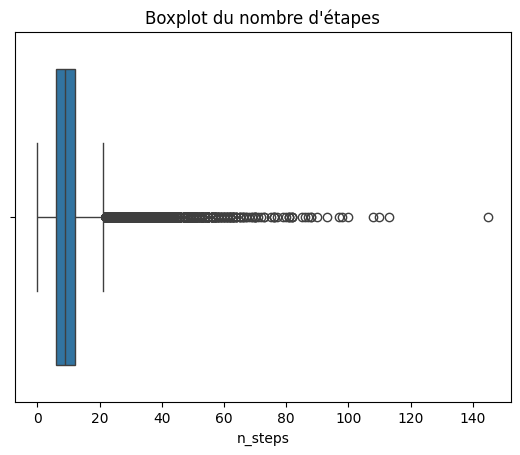

In [18]:
sns.boxplot(x='n_steps', data=recipes)
plt.title("Boxplot du nombre d'étapes")
plt.xlabel("n_steps")
plt.show()

- Le boxplot du nombre d'étapes (`n_steps`) montre une distribution très asymétrique, avec une majorité de recettes ayant peu d'étapes et une longue "queue" de valeurs élevées.
- On observe de nombreux outliers au-dessus de la borne supérieure du boxplot, ce qui indique la présence de recettes particulièrement complexes ou de valeurs aberrantes.

In [19]:
recipes['n_steps'].describe()

count    231635.000000
mean          9.765506
std           5.995153
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max         145.000000
Name: n_steps, dtype: float64

- La moyenne de la colonne n_steps étant aux alentours de 10 étapes et le maximum à 145 avec un écart-type de 6, nous pouvons proposer de concaténer le n_steps en catégories :
    - Simple (1-5 étapes)
    - Modéré (6-10 étapes)
    - Complexe (11-20 étapes)
    - Très complexe (>20 étapes)

In [20]:
# Catégorisation simple pour l'analyse
def categorize_complexity(n_steps):
    if n_steps <= 5: return "Simple"
    elif n_steps <= 10: return "Modéré" 
    elif n_steps <= 20: return "Complexe"
    else: return "Très complexe"

recipes['complexity'] = recipes['n_steps'].apply(categorize_complexity)

# Distribution par complexité
complexity_dist = recipes['complexity'].value_counts()
print(f"\n Distribution par complexité:")
for category, count in complexity_dist.items():
    pct = count/len(recipes)*100
    print(f"• {category}: {count:,} recettes ({pct:.1f}%)")


 Distribution par complexité:
• Modéré: 95,227 recettes (41.1%)
• Complexe: 70,699 recettes (30.5%)
• Simple: 53,686 recettes (23.2%)
• Très complexe: 12,023 recettes (5.2%)


/var/folders/zt/2nggs7pd3d5c9ymyqz8z2mm00000gn/T/ipykernel_57711/932444156.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=recipes[recipes['complexity'] == "Très complexe"], x='complexity', y='n_steps', ax=ax2, palette='viridis')


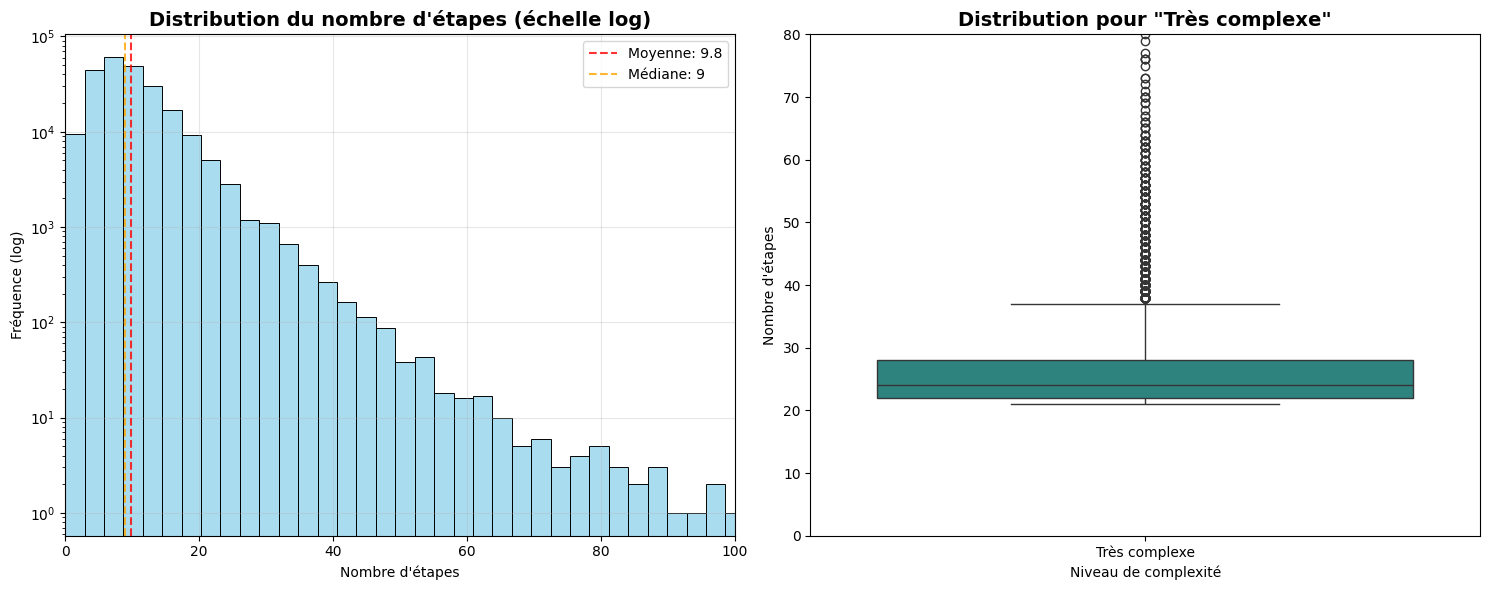

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Histogramme avec échelle logarithmique sur l'axe Y (pour voir les queues)
sns.histplot(data=recipes, x='n_steps', bins=50, kde=False, ax=ax1, alpha=0.7, color='skyblue')
ax1.axvline(recipes['n_steps'].mean(), color='red', linestyle='--', alpha=0.8, label=f'Moyenne: {recipes["n_steps"].mean():.1f}')
ax1.axvline(recipes['n_steps'].median(), color='orange', linestyle='--', alpha=0.8, label=f'Médiane: {recipes["n_steps"].median():.0f}')
ax1.set_title('Distribution du nombre d\'étapes (échelle log)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Nombre d\'étapes')
ax1.set_ylabel('Fréquence (log)')
ax1.set_yscale('log')  # Échelle logarithmique pour mieux voir les queues
ax1.legend()
ax1.set_xlim(0, 100)
ax1.grid(True, alpha=0.3)

# 2. Boxplot uniquement pour la catégorie "Très complexe"
sns.boxplot(data=recipes[recipes['complexity'] == "Très complexe"], x='complexity', y='n_steps', ax=ax2, palette='viridis')
ax2.set_title('Distribution pour "Très complexe"', fontsize=14, fontweight='bold')
ax2.set_xlabel('Niveau de complexité')
ax2.set_ylabel('Nombre d\'étapes')
ax2.set_ylim(0, 80)

plt.tight_layout()
plt.show()


- Utilisation de l'échelle log verticale pour l'histogramme du nombre d'étapes pour mieux visualiser la queue de la distribution et les outliers.
- Boxplot uniquement pour la catégorie "Très complexe" pour mieux visualiser les statistiques descriptives et la présence d'outliers dans cette catégorie.



In [22]:
recipes[recipes['n_steps'] >= 40]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,complexity
69,now and later vegetarian empanadas,38276,90.0,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,"['carrots', 'butter', 'onion', 'sliced mushroo...",22,Très complexe
316,any muffins,242,40.0,1530,1999-09-05,"['60-minutes-or-less', 'time-to-make', 'course...","[198.1, 9.0, 33.0, 7.0, 9.0, 16.0, 10.0]",44,"['bake 15 to 20 minutes in a 400 oven', 'for t...",muffins easy to adapt depending on your prefer...,"['white flour', 'milk', 'fat', 'egg', 'sugar',...",7,Très complexe
688,the best vegetarian vegan vegetable samosas,436082,80.0,1658961,2010-08-27,"['weeknight', 'time-to-make', 'course', 'cuisi...","[1316.6, 80.0, 41.0, 89.0, 52.0, 92.0, 62.0]",46,"['sift the flour and salt into a bowl', 'add t...",modified from: “madhur jaffrey’s world-of-the-...,"['all-purpose white flour', 'salt', 'unsalted ...",15,Très complexe
1150,24 karat cake,204393,80.0,185365,2007-01-08,"['time-to-make', 'course', 'preparation', 'low...","[1844.8, 172.0, 642.0, 39.0, 28.0, 205.0, 68.0]",45,"['prepare cake:', 'place oil in mixing bowl of...","this recipe is from ""fiftyfive restaurant grou...","['vegetable oil', 'granulated sugar', 'flour',...",18,Très complexe
1567,5 minute artisan bread,325571,30.0,292979,2008-09-18,"['30-minutes-or-less', 'time-to-make', 'prepar...","[783.3, 4.0, 2.0, 109.0, 52.0, 2.0, 53.0]",45,"['preparing dough for storage:', 'warm the wat...",this is the basic 'boule' bread mix from the b...,"['water', 'granulated yeast', 'kosher salt', '...",4,Très complexe
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229661,yukon gold cinnamon rolls,357611,130.0,118840,2009-02-24,"['time-to-make', 'course', 'main-ingredient', ...","[581.2, 34.0, 151.0, 26.0, 21.0, 66.0, 28.0]",40,"['for dough:', 'combine potatoes , 2 cups wate...",potatoes help make the dough amazingly moist a...,"['yukon gold potato', 'kosher salt', 'unsalted...",13,Très complexe
229673,yule log,350964,75.0,1135173,2009-01-21,"['time-to-make', 'course', 'preparation', 'occ...","[3590.6, 107.0, 2464.0, 63.0, 143.0, 175.0, 23...",48,"['separate the 5 yolks from whites , obviously...","an easy, but delicious chocolate christmas yul...","['eggs', 'sugar', 'cake flour', 'cocoa powder'...",13,Très complexe
229681,yuletide refrigerator yeast dough,5210,80.0,125579,1999-12-15,"['time-to-make', 'course', 'preparation', 'occ...","[423.6, 20.0, 143.0, 13.0, 14.0, 31.0, 24.0]",58,"['lightly spoon flour into measuring cup', 'le...",--adopted recipe--nutrition information will n...,"['flour', 'sugar', 'salt', 'nutmeg', 'active d...",18,Très complexe
230830,zopf great tasting swiss bread,353871,125.0,1157327,2009-02-04,"['time-to-make', 'course', 'preparation', 'for...","[303.0, 14.0, 2.0, 13.0, 16.0, 27.0, 15.0]",42,"['put the flour into a bowl', 'if you are usin...",this is a great bread recipe that was shown to...,"['flour', 'salt', 'milk', 'sugar', 'yeast', 'b...",8,Très complexe


- ajout d'un tri avec n_steps >= 40 & minutes >= 1200 (20 heures) pour repérer les recettes les plus longues et complexes, potentiellement des erreurs ou des recettes très particulières (fermentations, etc.).

### Traitement : 'n_ingredients'

## Traitement : Interactions

In [23]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


### Traitement : 'rating'

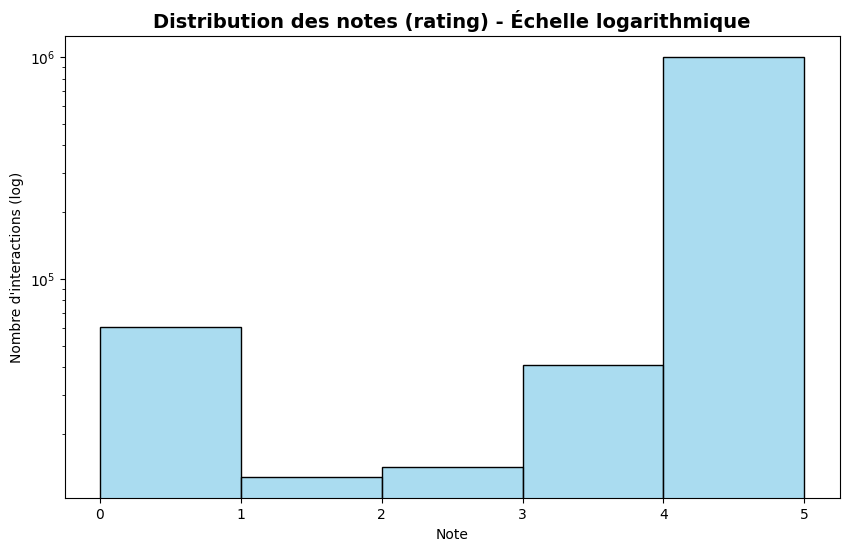

In [24]:
plt.figure(figsize=(10, 6))
bins = np.arange(0, 6, 1)  # De 0 à 5 par pas de 1
sns.histplot(interactions['rating'], bins=bins, kde=False, color='skyblue', alpha=0.7)
plt.title("Distribution des notes (rating) - Échelle logarithmique", fontsize=14, fontweight='bold')
plt.xlabel("Note")
plt.ylabel("Nombre d'interactions (log)")
plt.yscale('log')  # Échelle logarithmique pour mieux voir les détails
plt.xticks(range(int(interactions['rating'].min()), int(interactions['rating'].max()) + 1))

plt.show()

- on regarde les notes à 0 :

In [25]:
interactions[interactions['rating'] == 0]

,user_id,recipe_id,date,rating,review
6,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo..."
12,468945,134728,2008-02-20,0,Made my own buttermilk w/ vinegar and milk. U...
23,681408,225241,2008-03-14,0,This is a very good recipe. We also want to c...
39,2002068522,29093,2018-03-26,0,i made it and it was amazing
56,980899,79222,2010-10-18,0,"I used half cream and half 1% milk, added anot..."
...,...,...,...,...,...
1132318,1197076,190261,2010-03-08,0,Delicious ! I tweeked the recipe a bit>>substi...
1132323,2405600,290157,2014-11-10,0,Just added this mix to a homemade beef &amp; s...
1132325,2000650711,290157,2017-04-10,0,Would this make a good hamburger patty seasoning?
1132361,102526,54493,2007-04-26,0,I am not going to rate this because I did have...


- Il semblerait que les notes à 0 soient simplement des commentaires sans évaluation chiffrée, ou des évaluations non renseignées.


In [26]:
# Calcul du nombre et du pourcentage d'interactions avec rating = 0
nb_rating_0 = (interactions['rating'] == 0).sum()
pct_rating_0 = nb_rating_0 / len(interactions) * 100
print(f"Nombre d'interactions avec rating = 0 : {nb_rating_0:,} ({pct_rating_0:.2f}%)")

Nombre d'interactions avec rating = 0 : 60,847 (5.37%)


- Nous faisons le choix de les passer à NA pour ne pas biaiser l'analyse des notes réelles (1 à 5).
- Elles constituent une part non négligeable des intéractions, ce qui suggère que de nombreux utilisateurs laissent des commentaires sans évaluer la recette.

In [27]:
# Indiquer NA pour les ratings = 0
interactions.loc[interactions['rating'] == 0, 'rating'] = pd.NA

### Traitement : 'review'

In [28]:
# Afficher les lignes sans commentaire textuel
interactions[interactions['review'].isna()].head()

,user_id,recipe_id,date,rating,review
4141,2000971998,169916,2018-02-21,5.0,NaN
8206,2001494017,26110,2017-09-29,5.0,NaN
11235,2001434346,228641,2017-08-05,5.0,NaN
15813,2002307795,93886,2018-10-21,5.0,NaN
20448,2002265388,139918,2018-09-03,4.0,NaN


In [29]:
# Calcul du nombre et du pourcentage d'interactions sans commentaire textuel
nb_no_review = interactions['review'].isna().sum()
pct_no_review = nb_no_review / len(interactions) * 100
print(f"Nombre d'interactions sans commentaire textuel : {nb_no_review:,} ({pct_no_review:.2f}%)")

# Calcul de la note moyenne pour les interactions sans commentaire textuel
mean_rating_no_review = interactions.loc[interactions['review'].isna(), 'rating'].mean()
print(f"Note moyenne des interactions sans commentaire textuel : {mean_rating_no_review:.2f}")

Nombre d'interactions sans commentaire textuel : 169 (0.01%)
Note moyenne des interactions sans commentaire textuel : 4.72


In [30]:
# Analyse de la longueur des commentaires
interactions['review_length'] = interactions['review'].str.len()

# Statistiques descriptives sur la longueur des reviews
interactions['review_length'].describe()

count    1.132198e+06
mean     2.784095e+02
std      1.973972e+02
min      1.000000e+00
25%      1.470000e+02
50%      2.370000e+02
75%      3.580000e+02
max      8.587000e+03
Name: review_length, dtype: float64

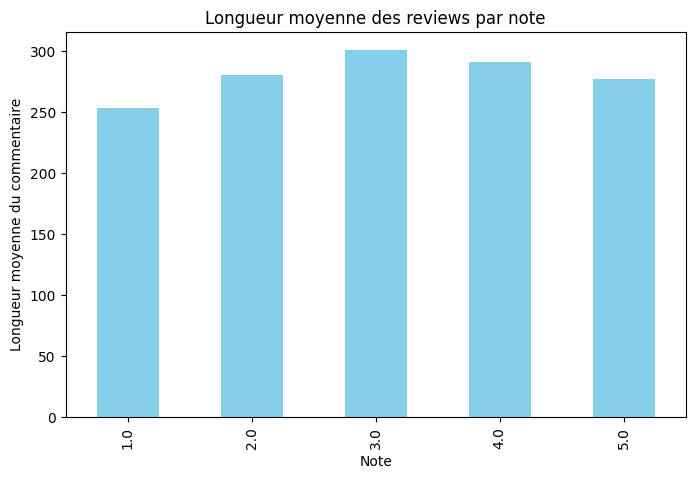

In [31]:
# Calculer la longueur moyenne des reviews par rating
mean_review_length_by_rating = interactions.groupby('rating')['review_length'].mean()

plt.figure(figsize=(8, 5))
mean_review_length_by_rating.plot(kind='bar', color='skyblue')
plt.title("Longueur moyenne des reviews par note")
plt.xlabel("Note")
plt.ylabel("Longueur moyenne du commentaire")
plt.show()


## Préparation des données pour l'analyse univariée de la popularité

### Agrégations par recette

In [32]:
recipe_metrics = interactions.groupby('recipe_id').agg({
    'rating': ['count', 'mean', 'median', 'std'],
    'user_id': 'nunique', # Nombre d'utilisateurs uniques ayant noté la recette
    'review': lambda x: x.notna().sum() # Nombre de reviews avec texte
}).round(3) # Arrondir à 3 décimales

# Applatir les colonnes multi-niveaux
recipe_metrics.columns = ['n_interactions', 'avg_rating', 'median_rating', 'std_rating', 'n_unique_users', 'n_reviews_text'] # n_ratings --> n_interactions pour plus de clarté

In [33]:
recipe_metrics.head(10)

,n_interactions,avg_rating,median_rating,std_rating,n_unique_users,n_reviews_text
recipe_id,,,,,,
38,4,4.250,4.0,0.500,4,4
39,1,3.000,3.0,NaN,1,1
40,9,4.333,5.0,1.323,9,9
41,2,4.500,4.5,0.707,2,2
43,1,1.000,1.0,NaN,1,1
45,2,4.000,4.0,1.414,3,3
46,2,5.000,5.0,0.000,2,2
48,1,2.000,2.0,NaN,2,2
49,18,4.833,5.0,0.383,20,20


### Ajout de métriques robustes de popularité : Bayésienne + Wilson

In [34]:
# Bayesian Average Rating (BAR)
global_mean = interactions['rating'].mean()
prior_count = 10  # Nombre de "votes" fictifs = Paramètre bayésien

# Calcul du BAR pour chaque recette
recipe_metrics['bayes_mean'] = (
    (recipe_metrics['avg_rating'] * recipe_metrics['n_interactions'] + global_mean * prior_count) /
    (recipe_metrics['n_interactions'] + prior_count)
).round(3)

- L’ajout de la moyenne bayésienne (Bayesian Average Rating) permet de corriger le biais lié au faible nombre d’interactions pour certaines recettes. Contrairement à la moyenne classique, cette approche intègre une "prior" globale et réduit l’impact des recettes peu notées qui pourraient apparaître artificiellement en tête du classement. 
- Cela garantit une comparaison plus robuste et équitable entre toutes les recettes, en tenant compte à la fois de la qualité perçue et de la quantité d’avis disponibles. 
- Cette statistique sera donc privilégiée pour l’analyse de la popularité afin d’éviter les effets de bord dus aux extrêmes ou aux recettes peu évaluées.

In [35]:
# Wilson Lower Bound (WLB) pour les notes binaires (4-5 étoiles = positif)
def wilson_lower_bound(positives, total, confidence=0.95):
    if total == 0:
        return 0
    p = positives / total
    z = 1.96 if confidence == 0.95 else 1.64  # z-score
    denominator = 1 + z**2 / total
    center = (p + z**2 / (2 * total)) / denominator
    margin = z * np.sqrt((p * (1 - p) + z**2 / (4 * total)) / total) / denominator
    return max(0, center - margin)

Le score Wilson Lower Bound (WLB) est une méthode statistique permettant d’estimer une borne inférieure de confiance pour la proportion de notes positives (ici, les notes ≥ 4) d’une recette, en tenant compte du nombre total de votes et de la variabilité. 

Contrairement à une simple proportion, le WLB pénalise les recettes avec peu de votes et donne une estimation plus prudente de la popularité réelle. Il est particulièrement utile pour éviter que des recettes peu évaluées mais avec uniquement des avis positifs ne soient surclassées dans le classement.

La formule utilisée est :

$$
WLB = \frac{p + \frac{z^2}{2n} - z \sqrt{\frac{p(1-p) + \frac{z^2}{4n}}{n}}}{1 + \frac{z^2}{n}}
$$

où :
- $p$ = proportion de notes positives (≥ 4)
- $n$ = nombre total de notes
- $z$ = score de confiance (1.96 pour 95%)

Ce score représente la borne inférieure de l’intervalle de confiance à 95% pour la proportion de notes positives. Plus le nombre de votes est élevé, plus la borne est proche de la proportion réelle. Pour les recettes peu notées, le score est fortement réduit, ce qui limite les faux positifs dans le classement de popularité.

In [36]:
# Calculer Wilson LB
ratings_by_recipe = interactions.groupby('recipe_id')['rating'].apply(list).to_dict()
wilson_scores = {}
for recipe_id, ratings in ratings_by_recipe.items():
    ratings_clean = [r for r in ratings if pd.notna(r)]
    if ratings_clean:
        positives = sum(1 for r in ratings_clean if r >= 4)
        total = len(ratings_clean)
        wilson_scores[recipe_id] = wilson_lower_bound(positives, total)
    else:
        wilson_scores[recipe_id] = 0

recipe_metrics['wilson_lb'] = recipe_metrics.index.map(wilson_scores)

### Jointure avec Recipes + métriques temporelles

In [37]:
# Convertir 'submitted' en datetime
recipes['submitted'] = pd.to_datetime(recipes['submitted'])
current_date = pd.Timestamp.now()  # Date de référence pour le calcul de l'ancienneté
recipes['age_months'] = ((current_date - recipes['submitted']).dt.days / 30.44).round(1)

In [38]:
# Jointure principale
df_analysis = recipes.merge(recipe_metrics, left_on='id', right_index=True, how='inner')

- Choix d'une jointure 'inner' pour ne conserver que les recettes ayant au moins une interaction, ce qui correspond à notre problématique d'analyse de la popularité en fonction de l'effort culinaire.

In [39]:
# Métriques d'engagement normalisées par le temps
df_analysis['interactions_per_month'] = df_analysis['n_interactions'] / np.maximum(1, df_analysis['age_months'])

In [40]:
# Log transformation pour minutes (après avoir retiré les 0 et valeurs aberrantes)
df_analysis = df_analysis[df_analysis['minutes'].notna() & (df_analysis['minutes'] > 0)]
df_analysis['log_minutes'] = np.log(df_analysis['minutes'])

In [41]:
df_analysis.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,n_interactions,avg_rating,median_rating,std_rating,n_unique_users,n_reviews_text,bayes_mean,wilson_lb,interactions_per_month,log_minutes
0,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,3,5.000,5.0,0.000,3,3,4.740,0.438494,0.012464,4.007333
1,a bit different breakfast pizza,31490,30.0,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,3,4.667,5.0,0.577,4,4,4.663,0.438494,0.010726,3.401197
2,all in the kitchen chili,112140,130.0,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,1,4.000,4.0,NaN,1,1,4.601,0.206543,0.004042,4.867534
3,alouette potatoes,59389,45.0,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,2,4.500,4.5,0.707,2,2,4.635,0.342372,0.007413,3.806662
4,amish tomato ketchup for canning,44061,190.0,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,1,5.000,5.0,NaN,1,1,4.692,0.206543,0.003631,5.247024


In [42]:
# Statistiques descriptives des métriques de popularité
popularity_cols = ['n_interactions', 'avg_rating', 'bayes_mean', 'wilson_lb', 'interactions_per_month']
df_analysis[popularity_cols].describe().round(3)

,n_interactions,avg_rating,bayes_mean,wilson_lb,interactions_per_month
count,230541.000,225528.000,225528.000,230541.000,230541.000
mean,4.629,4.582,4.654,0.344,0.020
std,16.446,0.629,0.106,0.204,0.062
min,0.000,1.000,3.144,0.000,0.000
25%,1.000,4.333,4.601,0.207,0.005
50%,2.000,4.889,4.692,0.342,0.009
75%,4.000,5.000,4.718,0.438,0.018
max,1496.000,5.000,4.983,0.983,5.774


## 1) Analyse univariée de la popularité

### 1.1) Visualisation des distributions des métriques de popularité

In [43]:
# Calcul du nombre optimal de bins avec la règle de Freedman-Diaconis
    # bins = (max - min) / (2*IQR/n^(1/3))
def freedman_diaconis_bins(data):
        data_clean = data.dropna()
        n = len(data_clean)
        q75, q25 = np.percentile(data_clean, [75, 25])
        iqr = q75 - q25
        if iqr > 0:
            bin_width = 2 * iqr / (n ** (1/3))
            bins = int(np.ceil((data_clean.max() - data_clean.min()) / bin_width))
        else:
            bins = int(np.ceil(np.sqrt(n)))  # Fallback
            
        # Limiter entre 10 et 100 bins
        return max(10, min(100, bins))

- Utilisation de la règle de Freedman-Diaconis pour déterminer le nombre optimal de bins pour les histogrammes des métriques de popularité, afin de mieux capturer la distribution des données tout en minimisant le bruit.

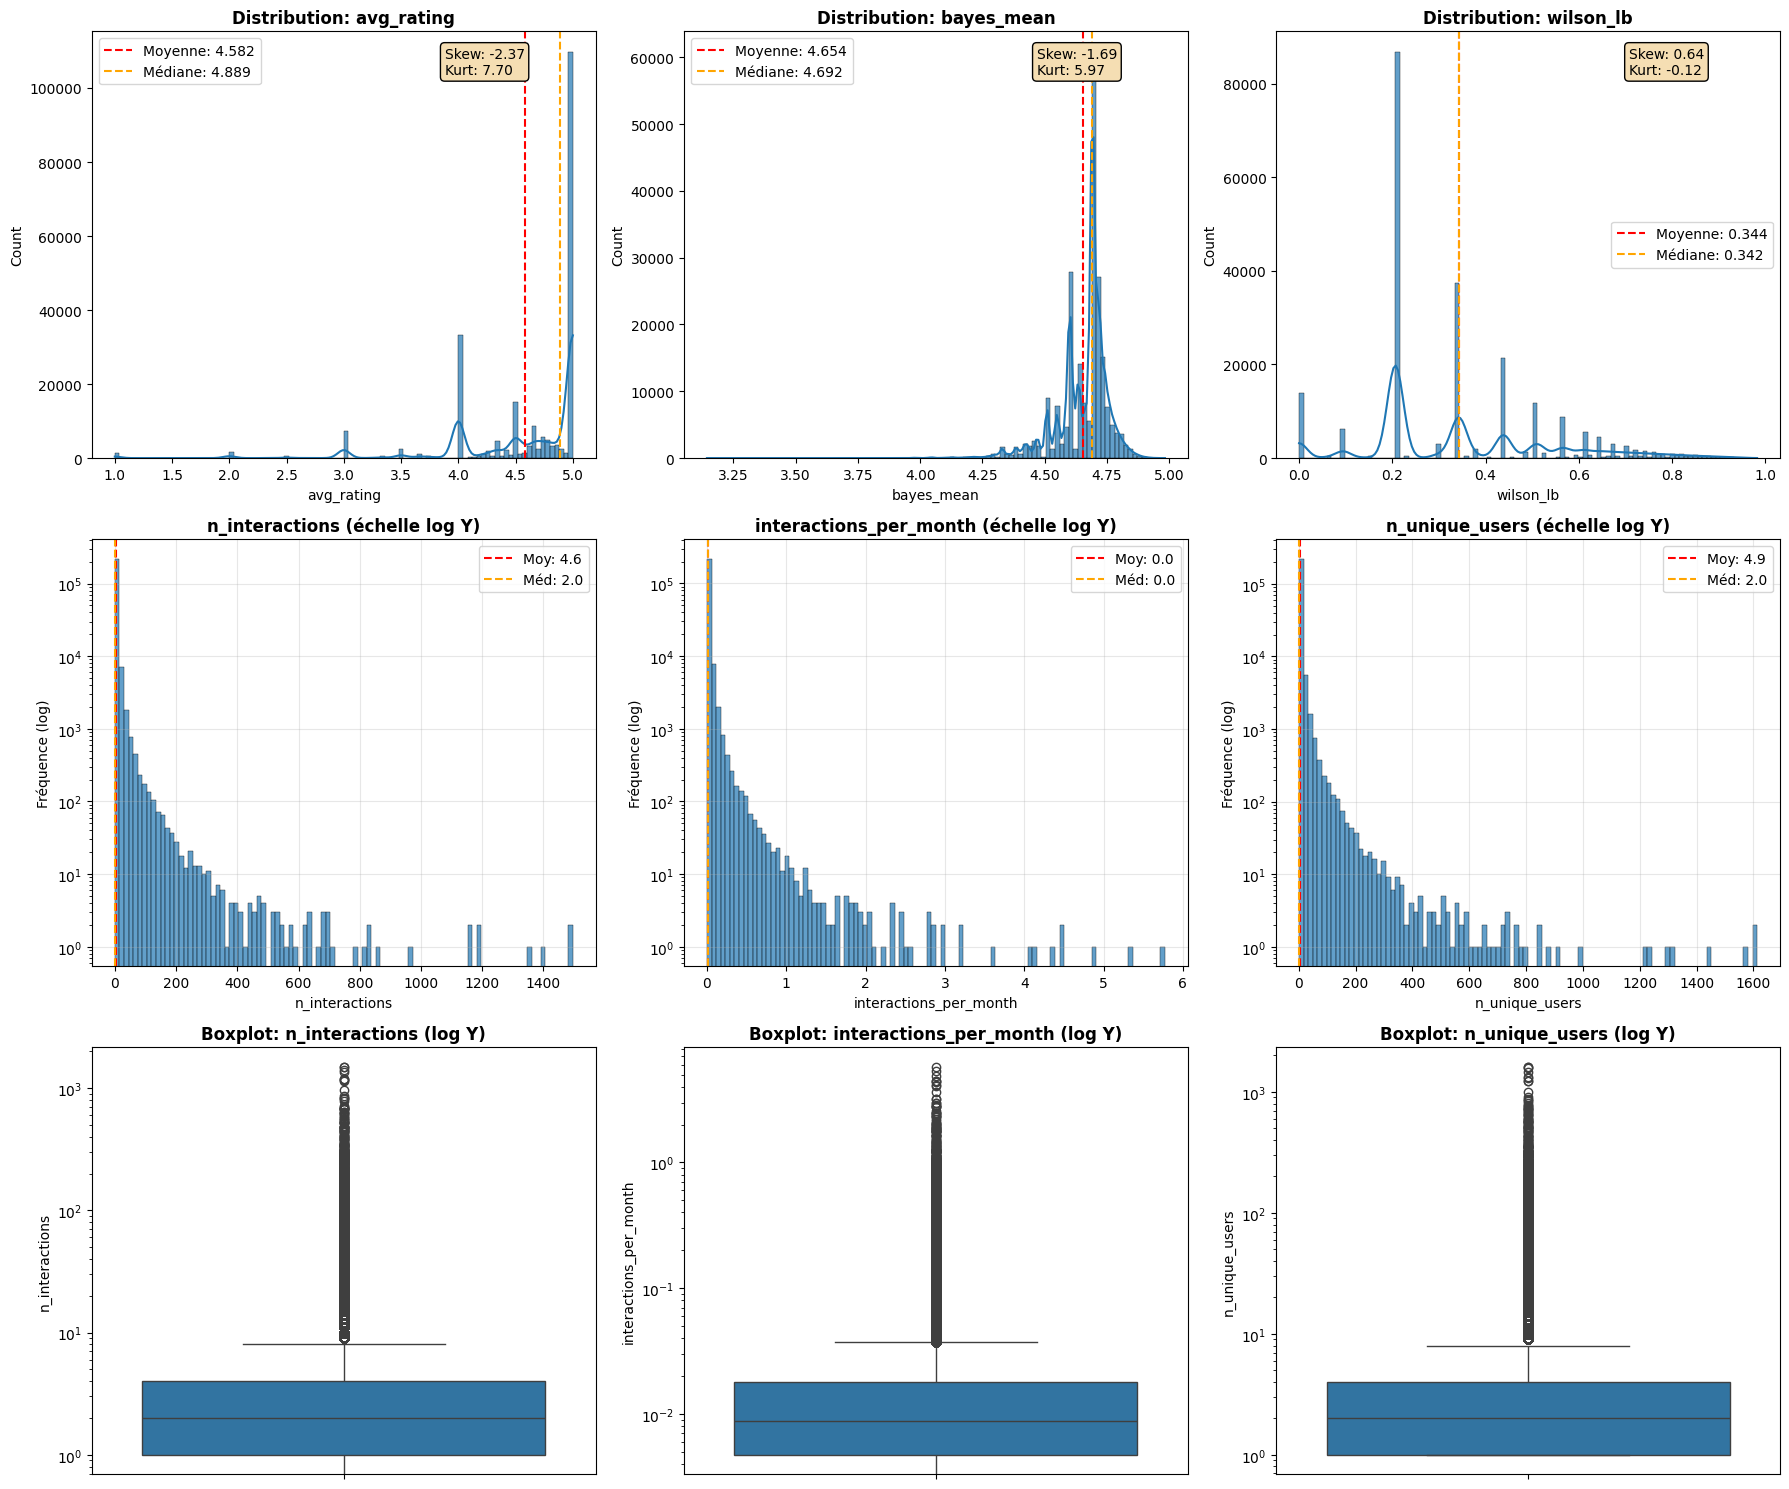

In [44]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 1- Satisfaction: Qualité perçue via les ratings
satisfaction_vars = ['avg_rating', 'bayes_mean', 'wilson_lb']

for i, var in enumerate(satisfaction_vars):
    optimal_bins = freedman_diaconis_bins(df_analysis[var])
    # Histogramme
    sns.histplot(df_analysis[var], bins = optimal_bins, kde=True, ax=axes[0, i], alpha=0.7)
    axes[0, i].set_title(f'Distribution: {var}', fontweight='bold')
    axes[0, i].axvline(df_analysis[var].mean(), color='red', linestyle='--', 
                       label=f'Moyenne: {df_analysis[var].mean():.3f}')
    axes[0, i].axvline(df_analysis[var].median(), color='orange', linestyle='--',
                       label=f'Médiane: {df_analysis[var].median():.3f}')
    axes[0, i].legend()
    
    # Statistiques
    skew = df_analysis[var].skew()
    kurt = df_analysis[var].kurtosis()
    axes[0, i].text(0.7, 0.9, f'Skew: {skew:.2f}\nKurt: {kurt:.2f}', 
                    transform=axes[0, i].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

# 2- Engagement: popularité via le volume/rythme des interactions
engagement_vars = ['n_interactions', 'interactions_per_month', 'n_unique_users']

for i, var in enumerate(engagement_vars):
    optimal_bins = freedman_diaconis_bins(df_analysis[var])
    # Vérifier si très asymétrique
    is_skewed = df_analysis[var].skew() > 2
    
    # Histogramme
    sns.histplot(df_analysis[var], bins = optimal_bins, kde=False, ax=axes[1, i], alpha=0.7)
    
    # Appliquer échelle log AVANT les lignes verticales et labels
    if is_skewed:
        axes[1, i].set_yscale('log')
        axes[1, i].set_ylabel('Fréquence (log)')
        axes[1, i].set_title(f'{var} (échelle log Y)', fontweight='bold')
    else:
        axes[1, i].set_ylabel('Fréquence')
        axes[1, i].set_title(f'Distribution: {var}', fontweight='bold')
    
    # Lignes verticales APRÈS l'échelle log
    axes[1, i].axvline(df_analysis[var].mean(), color='red', linestyle='--', 
                       label=f'Moy: {df_analysis[var].mean():.1f}')
    axes[1, i].axvline(df_analysis[var].median(), color='orange', linestyle='--',
                       label=f'Méd: {df_analysis[var].median():.1f}')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)
    
    # Boxplot correspondant
    sns.boxplot(y=df_analysis[var], ax=axes[2, i])
    if is_skewed:
        axes[2, i].set_yscale('log')
        axes[2, i].set_title(f'Boxplot: {var} (log Y)', fontweight='bold')
    else:
        axes[2, i].set_title(f'Boxplot: {var}', fontweight='bold')

plt.tight_layout()
plt.show()

**Conclusions sur cette première analyse univariée de la popularité des recettes :**
- Métriques de satisfaction (avg_rating, bayes_mean, wilson_lb) :
  - Distributions globalement centrées autour de 4-4.5, indiquant une satisfaction généralement élevée.
  - Présence d'une légère asymétrie positive, avec quelques recettes très bien notées.
  - La moyenne bayésienne et le score Wilson sont plus conservateurs, réduisant l'impact des recettes peu notées.
- Métriques d'engagement (n_interactions, interactions_per_month, n_unique_users) :
  - Distributions très asymétriques, avec une majorité de recettes ayant peu d'interactions et quelques recettes très populaires.
  - Peu de recettes très populaires et beaucoup de recettes peu populaires, ce qui souligne l'importance de quelques "hits" (recettes virales, tendance).
  - La majorité des recettes ont moins de 100 interactions, avec une longue traîne de recettes très populaires.
  - L'échelle logarithmique est nécessaire pour visualiser correctement ces distributions.

### 1.2) Transformations avancées des données, ajout de métriques dérivées

In [45]:
# Versions log1p des métriques d'engagement
for var in engagement_vars:
    df_analysis[f'log1p_{var}'] = np.log1p(df_analysis[var].clip(lower=0))

np.log1p(x) est une fonction qui calcule le logarithme naturel de (1 + x) et reste définie pour x = 0, évitant ainsi les problèmes liés au logarithme de zéro.
Pour les métriques d'engagement très asymétriques, cela permet de:
- Réduire l'impact des valeurs extrêmes en compressant la plage des données.
- Mieux visualiser la distribution des données, en particulier pour les valeurs faibles.
- Rapprocher la distribution des données d'une forme plus normale, facilitant ainsi l'analyse statistique ultérieure.

In [46]:
# Winsorization pour réduire l'impact des valeurs extrêmes
def winsorize(series, lower_pct=0.05, upper_pct=0.99):
    lower_bound = series.quantile(lower_pct)
    upper_bound = series.quantile(upper_pct)
    return series.clip(lower=lower_bound, upper=upper_bound)

for var in ["log_minutes", "log1p_n_interactions", "log1p_interactions_per_month", "log1p_n_unique_users"]:
    df_analysis[f"{var}_w"] = winsorize(df_analysis[var])

On applique une winsorization pour réduire l'impact des valeurs extrêmes sur certaines métriques d'engagement. La winsorization consiste à limiter les valeurs extrêmes en les remplaçant par des percentiles définis (ici, le 5ème et le 99ème percentile). Cela permet de conserver la majorité des données tout en atténuant l'influence des outliers qui pourraient biaiser les analyses statistiques ou les visualisations.
- On utilisera les versions winsorisées (créées ici) pour les graphiques et corrélations ultérieures.

In [47]:
# Écart à la note maximale (5) pour les métriques de satisfaction
df_analysis["rating_gap"] = 5 - df_analysis["avg_rating"]
df_analysis["bayes_gap"] = 5 - df_analysis["bayes_mean"]
df_analysis["wilson_gap"] = 1 - df_analysis["wilson_lb"]

Ces écarts sont utiles pour identifier les recettes qui se démarquent en termes de satisfaction, en mettant en évidence celles qui sont proches de la note maximale (5) et celles qui s'en éloignent le plus. Cela peut aider à cibler les recettes à améliorer ou à promouvoir en fonction de leur performance relative.

### 1.3) Distributions après transformation

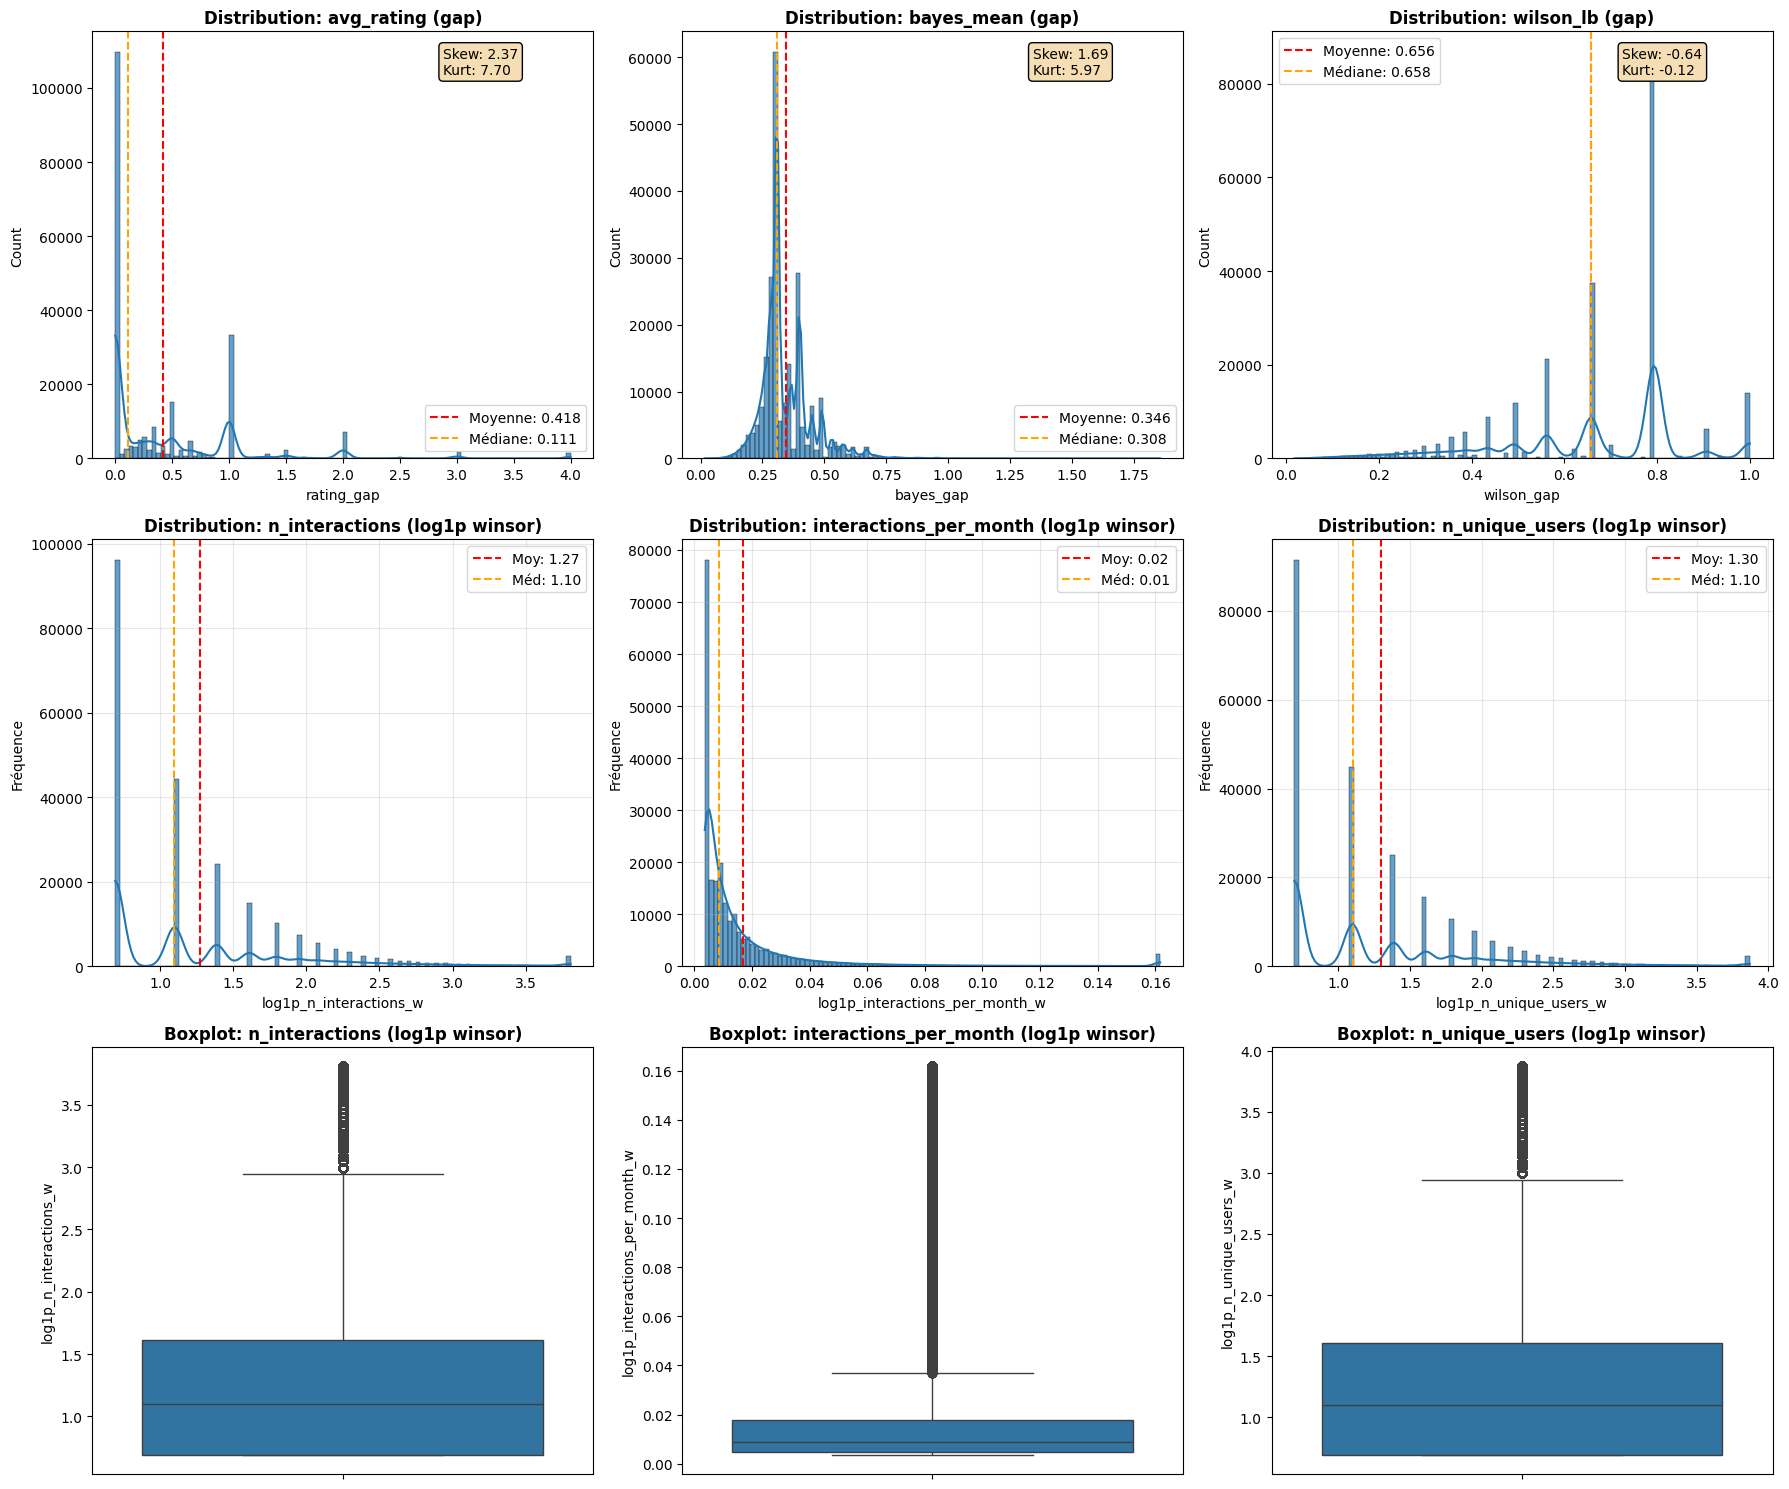

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

satisfaction_vars = {
    "avg_rating (gap)": "rating_gap",
    "bayes_mean (gap)": "bayes_gap",
    "wilson_lb (gap)": "wilson_gap"
}

engagement_vars = {
    "n_interactions (log1p winsor)": "log1p_n_interactions_w",
    "interactions_per_month (log1p winsor)": "log1p_interactions_per_month_w",
    "n_unique_users (log1p winsor)": "log1p_n_unique_users_w"
}

for col_idx, (title, col) in enumerate(satisfaction_vars.items()):
    data = df_analysis[col].dropna()
    bins = freedman_diaconis_bins(data)
    sns.histplot(data, bins=bins, kde=True, ax=axes[0, col_idx], alpha=0.7)
    axes[0, col_idx].set_title(f"Distribution: {title}", fontweight="bold")
    axes[0, col_idx].axvline(data.mean(), color="red", linestyle="--", label=f"Moyenne: {data.mean():.3f}")
    axes[0, col_idx].axvline(data.median(), color="orange", linestyle="--", label=f"Médiane: {data.median():.3f}")
    axes[0, col_idx].legend()
    axes[0, col_idx].text(0.70, 0.9, f"Skew: {data.skew():.2f}\nKurt: {data.kurtosis():.2f}",
                          transform=axes[0, col_idx].transAxes,
                          bbox=dict(boxstyle="round", facecolor="wheat"))

for col_idx, (title, col) in enumerate(engagement_vars.items()):
    data = df_analysis[col].dropna()
    bins = freedman_diaconis_bins(data)
    sns.histplot(data, bins=bins, kde=True, ax=axes[1, col_idx], alpha=0.7)
    axes[1, col_idx].set_ylabel("Fréquence")
    axes[1, col_idx].set_title(f"Distribution: {title}", fontweight="bold")
    axes[1, col_idx].axvline(data.mean(), color="red", linestyle="--", label=f"Moy: {data.mean():.2f}")
    axes[1, col_idx].axvline(data.median(), color="orange", linestyle="--", label=f"Méd: {data.median():.2f}")
    axes[1, col_idx].legend()
    axes[1, col_idx].grid(True, alpha=0.3)

    sns.boxplot(y=data, ax=axes[2, col_idx])
    axes[2, col_idx].set_title(f"Boxplot: {title}", fontweight="bold")

plt.tight_layout()
plt.show()


**Commentaires sur les distributions après transformation :**
- Les variables rating_gap, bayes_gap montrent une distribution plus concentrée vers 0, indiquant que la majorité des recettes ont des notes proches de 5. La plupart des recettes restent à moins de quelques dizièmes de point de la note maximale. Le léger allongement de la queue vers la droite correspond aux recettes réellement pénalisées par les utilisateurs. Les médianes (en jaune/orange) sont très proches de 0, confirmant que la majorité des recettes sont bien notées.
- Les versions log1p des métriques d'engagement (après winsorization) montrent une distribution plus symétrique et moins étirée, facilitant l'analyse. Le coeur de la distribution est mieux visualisé ce qui met enfin en évidence les recettes au volume d'intéractions "normal" sans qu'elles soient écrasées par les quelques recettes très populaires.
- Les boxplots montrent encore une présence d'outliers, mais ils sont désormais moins extrêmes grâce à la winsorization et sont compatibles avec les analyses corrélationnelles ou linéaires ultérieures.

Globalement, la combinaison de log1p et de la winsorization permet de stabiliser la variance et de réduire la kurtosis des métriques d'engagement, rendant les distributions plus adaptées à une analyse statistique approfondie.

## 2) Analyse bivariée